In [21]:
import pandas as pd
import numpy as np
import json
import math
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [22]:
VIDEO_CSV_PATH = "video_data.json"
CATEGORIES_JSON_PATH = "video_categories.json"
CHANNEL_JSON_PATH = "channel_data (1).json"


In [23]:
video_raw = pd.read_json(VIDEO_CSV_PATH, lines=True)
print("Video data shape:", video_raw.shape)
display(video_raw.head())

with open(CATEGORIES_JSON_PATH, "r", encoding="utf-8") as f:
    categories_raw = json.load(f)

print("Category JSON keys:", categories_raw.keys())
print("Number of category items:", len(categories_raw.get("items", [])))

cat_map = {
    int(item["id"]): item["snippet"]["title"]
    for item in categories_raw["items"]
}
with open(CHANNEL_JSON_PATH, "r", encoding="utf-8") as f:
    channel_list = json.load(f)

channel_df = pd.DataFrame(channel_list)
print("Channel data shape:", channel_df.shape)
display(channel_df.head())

Video data shape: (440772, 13)


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror"
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ..."
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,..."


Category JSON keys: dict_keys(['kind', 'etag', 'items'])
Number of category items: 32
Channel data shape: (1561, 11)


,channel_id,channel_title,description,custom_url,created_at,thumbnail,country,view_count,subscriber_count,hidden_subscribers,video_count
0,UC6sfgGx5u8qCpWeqMxFWpjQ,Crypto Trade1,Cryptotrade1 is basically providing trading si...,@cryptotrade1,2017-11-14T07:12:04Z,https://yt3.ggpht.com/vR-Cl98vUxtqxKOOh9YwDC7_...,AE,32872,1140,false,376
1,UCwQp7Wc1NIKrW4UTOgOmVKg,The Meaning Of Islam,"Assalam Alaikum!\nI’m Ayesha, the creator of “...",@themeaningofislam,2011-10-26T09:33:39Z,https://yt3.ggpht.com/ytc/AGIKgqP8TvqgrQpOpLiT...,AE,88557098,503000,false,121
2,UCZ245tjtaxNCb0Y4i9H9AXQ,Fernando Romero Moreno,Por un Frente Nacional que defienda los valore...,@fernandoromeromoreno1519,2014-07-28T20:45:20Z,https://yt3.ggpht.com/ytc/AGIKgqPe8zceaOY-88SQ...,AR,15661,666,false,47
3,UCNDrlU4YJrjPwO0yB7SG-bg,Ojo de Halcón,None,@ojodehalcon,2017-09-11T03:18:17Z,https://yt3.ggpht.com/ytc/AGIKgqPj3rmRbMVZ_gmt...,AR,28714333,94400,false,3312
4,UCFHAPATvu8q49hy53VPv6SA,Red Internacional de Promotores ODS,Canal Oficial de videos de la Red Internaciona...,@redinternacionaldepromotor7015,2020-02-22T17:10:07.38079Z,https://yt3.ggpht.com/ytc/AGIKgqOnCTiIM6cdyLSV...,AR,103219,5940,false,139


In [25]:
video_df = video_raw.copy()
video_df["category_title"] = video_df["category_id"].map(cat_map)
video_df["published_at"] = pd.to_datetime(video_df["published_at"], errors="coerce")
video_df["published_year"] = video_df["published_at"].dt.year
for col in ["view_count", "like_count", "favorite_count", "comment_count"]:
    video_df[col] = pd.to_numeric(video_df[col], errors="coerce")
video_df["like_count"] = video_df["like_count"].fillna(0)
video_df["comment_count"] = video_df["comment_count"].fillna(0)
video_df["like_rate"] = video_df["like_count"] / video_df["view_count"]
video_df["comment_rate"] = video_df["comment_count"] / video_df["view_count"]

print("Cleaned data shape:", video_df.shape)
display(video_df.head())

Cleaned data shape: (440772, 17)


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags,category_title,published_year,like_rate,comment_rate
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN,Film & Animation,2021,0.090909,0.000000
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN,Film & Animation,2021,0.153846,0.000000
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror",Film & Animation,2021,0.011422,0.001893
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ...",Film & Animation,2022,0.029371,0.001163
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,...",Film & Animation,2012,0.009978,0.000988


In [26]:
df_ml = video_df[["view_count", "like_count", "comment_count", "category_title"]].copy()
df_ml = df_ml[df_ml["view_count"] > 0]

y = np.log1p(df_ml["view_count"].values)

X_numeric = df_ml[["like_count", "comment_count"]]
X_cat = pd.get_dummies(df_ml["category_title"], prefix="cat", drop_first=True)

X = pd.concat([X_numeric, X_cat], axis=1)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
X.head()


Feature matrix shape: (439816, 17)
Target vector shape: (439816,)


,like_count,comment_count,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Trailers,cat_Travel & Events
0,1.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,175.0,29.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,457300.0,18103.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,293.0,29.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [43]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

df_lin = video_df[["view_count", "like_count", "comment_count", "category_title"]].copy()
df_lin = df_lin.dropna(subset=["view_count", "like_count", "comment_count", "category_title"])
df_lin = df_lin[df_lin["view_count"] > 0]

y_lin = np.log1p(df_lin["view_count"])
X_num_lin = df_lin[["like_count", "comment_count"]]
X_cat_lin = pd.get_dummies(df_lin["category_title"], prefix="cat", drop_first=True)
X_lin = pd.concat([X_num_lin, X_cat_lin], axis=1)

X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_lin, y_lin, test_size=0.2, random_state=42
)

lin_reg = LinearRegression()
lin_reg.fit(X_train_lin, y_train_lin)

y_pred_lin = lin_reg.predict(X_test_lin)
r2_lin = r2_score(y_test_lin, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))

print("Linear Regression R2:", r2_lin)
print("Linear Regression RMSE:", rmse_lin)
print("Top coefficients:")
coef_series_lin = pd.Series(lin_reg.coef_, index=X_lin.columns).sort_values(key=abs, ascending=False)
print(coef_series_lin.head(10))


Linear Regression R2: 0.17213161206336547
Linear Regression RMSE: 3.511599050646184
Top coefficients:
cat_Gaming                  -2.747620
cat_Trailers                 2.676123
cat_Music                    1.975395
cat_People & Blogs          -1.678861
cat_Travel & Events         -1.468861
cat_Comedy                   1.412473
cat_Nonprofits & Activism   -1.271980
cat_Howto & Style           -1.047864
cat_Pets & Animals          -0.752387
cat_Film & Animation         0.644109
dtype: float64


In [44]:
df_anom = video_df[["view_count", "comment_count"]].copy()
df_anom = df_anom.dropna(subset=["view_count", "comment_count"])
df_anom = df_anom[df_anom["view_count"] > 0]

df_anom["cv_rate"] = df_anom["comment_count"] / df_anom["view_count"]
mu = df_anom["cv_rate"].mean()
sigma = df_anom["cv_rate"].std()
df_anom["cv_zscore"] = (df_anom["cv_rate"] - mu) / sigma

threshold = 3.0
anomalies = df_anom[df_anom["cv_zscore"] > threshold]

print("Total videos:", len(df_anom))
print("Anomalies (z > 3):", len(anomalies))
print(anomalies.sort_values("cv_zscore", ascending=False).head(10))


Total videos: 439816
Anomalies (z > 3): 4080
        view_count  comment_count    cv_rate   cv_zscore
166376        42.0          449.0  10.690476  319.842864
87934          3.0            6.0   2.000000   59.646603
262283        21.0           38.0   1.809524   53.943671
261869        40.0           57.0   1.425000   42.430878
62996        548.0          733.0   1.337591   39.813825
376681         3.0            4.0   1.333333   39.686342
241573         3.0            4.0   1.333333   39.686342
62992        631.0          805.0   1.275753   37.962357
62993       1023.0         1290.0   1.260997   37.520566
179693       142.0          166.0   1.169014   34.766559


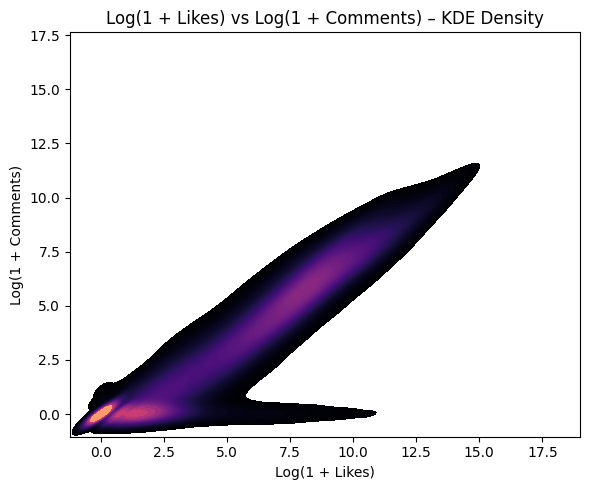

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_kde = video_df[["like_count", "comment_count"]].dropna().copy()

# Apply log1p transformation to handle skewed count data and zeros
df_kde["like_count_log"] = np.log1p(df_kde["like_count"])
df_kde["comment_count_log"] = np.log1p(df_kde["comment_count"])

plt.figure(figsize=(6,5))
sns.kdeplot(
    data=df_kde,
    x="like_count_log",
    y="comment_count_log",
    fill=True,
    thresh=0.05,
    levels=50,
    cmap="magma"
)
plt.xlabel("Log(1 + Likes)")
plt.ylabel("Log(1 + Comments)")
plt.title("Log(1 + Likes) vs Log(1 + Comments) – KDE Density")
plt.tight_layout()
plt.show()

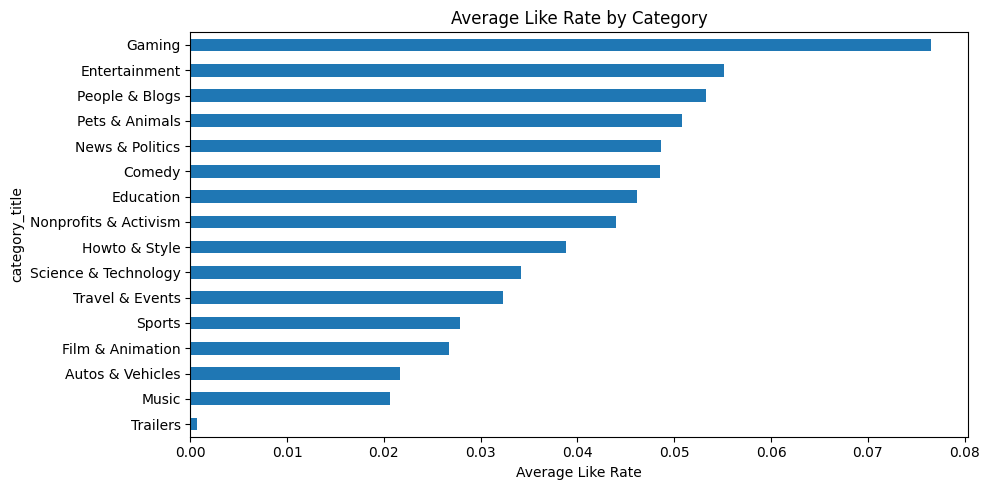

In [46]:
df_lr = video_df[["view_count", "like_count", "category_title"]].copy()
df_lr = df_lr.dropna(subset=["view_count", "like_count", "category_title"])
df_lr = df_lr[df_lr["view_count"] > 0]
df_lr["like_rate"] = df_lr["like_count"] / df_lr["view_count"]

cat_like_rate = df_lr.groupby("category_title")["like_rate"].mean().sort_values()

plt.figure(figsize=(10,5))
cat_like_rate.plot(kind="barh")
plt.xlabel("Average Like Rate")
plt.title("Average Like Rate by Category")
plt.tight_layout()
plt.show()




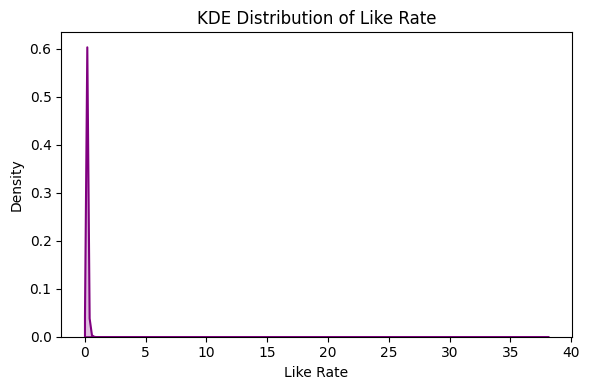

In [49]:
plt.figure(figsize=(6,4))
sns.kdeplot(like_rate_series, fill=True, linewidth=1.5, color="purple")
plt.xlabel("Like Rate")
plt.ylabel("Density")
plt.title("KDE Distribution of Like Rate")
plt.tight_layout()
plt.show()
